This code does a thing

In [ ]:
import rio_cogeo
import rasterio
import numpy as np

Difference in file size for np.int8 vs np.int32:

Int8 COG size: 508.81 MB
Int32 COG size: 721.00 MB
Size ratio (int32/int8): 1.42x


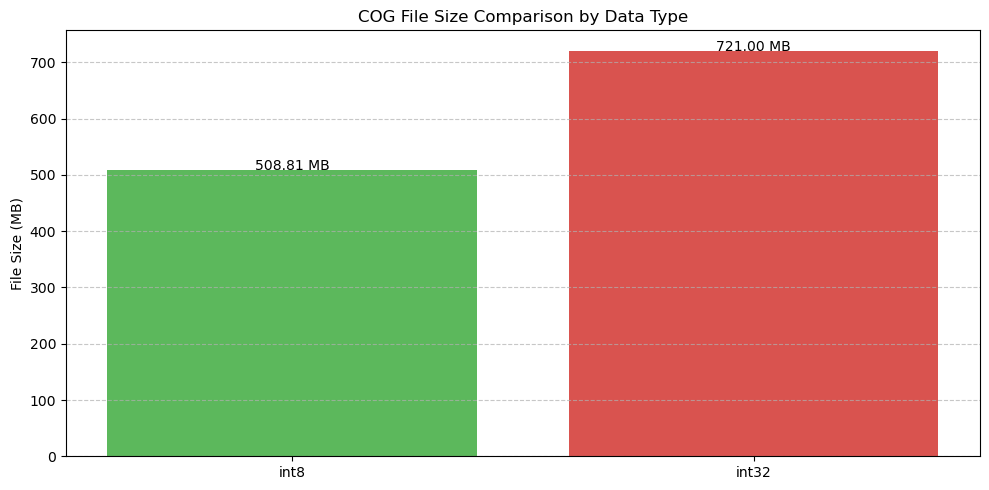

In [ ]:
import os
import numpy as np
import rasterio
from rasterio.transform import Affine
import matplotlib.pyplot as plt
from pathlib import Path
from rio_cogeo.cogeo import cog_translate
from rio_cogeo.profiles import cog_profiles

# Set random seed for reproducibility
np.random.seed(42)

# Create a directory for our test files
output_dir = Path("tmp")
output_dir.mkdir(exist_ok=True)

# Create synthetic raster data (2000x2000 pixels)
rows, cols = 2000, 2000
data = np.random.randint(-128, 127, size=(rows, cols))

# Create a temporary GeoTIFF to convert to COG
temp_tif = output_dir / "temp.tif"

# Define a simple geotransform
transform = Affine(10, 0, 0, 0, -10, 0)  # 10m pixels

# Function to save as temporary GeoTIFF with specified dtype
def create_temp_tif(data, output_path, dtype):
    profile = {
        'driver': 'GTiff',
        'height': data.shape[0],
        'width': data.shape[1],
        'count': 1,
        'dtype': dtype,
        'crs': 'EPSG:4326',
        'transform': transform
    }
    
    with rasterio.open(output_path, 'w', **profile) as dst:
        dst.write(data.astype(dtype), 1)

# Function to convert to COG with rio-cogeo
def convert_to_cog(src_path, dst_path):
    cog_profile = cog_profiles.get("deflate")
    cog_translate(src_path, dst_path, cog_profile, quiet=True)
    return os.path.getsize(dst_path)

# Test with int8 data type
create_temp_tif(data, temp_tif, np.int8)
int8_path = output_dir / "raster_int8_cog.tif"
int8_size = convert_to_cog(temp_tif, int8_path)

# Test with int32 data type
create_temp_tif(data, temp_tif, np.int32) 
int32_path = output_dir / "raster_int32_cog.tif"
int32_size = convert_to_cog(temp_tif, int32_path)

# Clean up temp file
if os.path.exists(temp_tif):
    os.remove(temp_tif)

# Report file sizes
print(f"Int8 COG size: {int8_size / 1024 / 1024:.2f} MB")
print(f"Int32 COG size: {int32_size / 1024 / 1024:.2f} MB")
print(f"Size ratio (int32/int8): {int32_size / int8_size:.2f}x")

# Plot comparison
labels = ['int8', 'int32']
sizes = [int8_size / 1024 / 1024, int32_size / 1024 / 1024]

plt.figure(figsize=(10, 5))
plt.bar(labels, sizes, color=['#5cb85c', '#d9534f'])
plt.ylabel('File Size (MB)')
plt.title('COG File Size Comparison by Data Type')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, size in enumerate(sizes):
    plt.text(i, size + 0.1, f"{size:.2f} MB", ha='center')

plt.tight_layout()
plt.show()